In [1]:
#This file is without whitening

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(1234)

In [3]:
#loading data and setting a few parameters

X = np.loadtxt('sensor_differences.txt')
t1 = np.loadtxt('sensor_time.txt')
c = 343
dt = 6.25e-05
#end_time = 500e-3
end_time = 5
show_plots = True
X.shape

X = X.T
print(X.shape)

(3, 79420)


In [4]:
#getting the coeffs for a filter

#This filter is used to calculate the DC level of the inputs as a function of time
# Centering the data in real time
from scipy import signal

corner = 1e0 #same unit as fs (Hz)
b, a = signal.butter(10, corner, 'lowpass', analog=True)
sos = signal.butter(10, corner, 'lowpass', fs=(1/dt), output='sos')
w, h = signal.freqs(b, a)
if show_plots:
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    #Might be rad/s?
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.show()

In [5]:
# noticed the de00 term was much larger than the others
# was leading to convergence issues 
# whitening does some sort of normalization (covariance matrix diagonals are ~1)
# (previously, the algorithm would overflow without whitening)
# => seemed reasonable to attempt to normalize the data before processing (make it roughly 
# same order of magnitude)
dividing_factor = 1e5

#havent tried dividing the other columns by the same factor

E = X
E.shape
E[0,:] /= dividing_factor

In [6]:
from scipy import signal
converged = False


#mu = learning rate
#mu = 1e-4
mu = 5e-6

#Non linear functions to test indepedence (HJ algorithm - See attached paper)
f        = lambda x: x**3   
#tanh seems to work too?
g        = lambda x: np.arctan(x)         

#Simpler functions - does not appear to separate well
# f = lambda x: np.sign(x)
# g = lambda x: x

#randomly initializing to very small values
# c12, c21 = np.random.rand(2)/1e5 # demixing coefficients
# c13, c31 = np.random.rand(2)/1e5
# c23, c32 = np.random.rand(2)/1e5

c12, c21 = 0.1, 0.1
c13, c31 = 0.1, 0.1
c23, c32 = 0.1, 0.1

C = np.array([[0, c12, c13], 
             [c21, 0, c23],
             [c31, c32, 0]])

#Matrix to store C at each iteration for debugging / plotting
C_debug = np.empty((3,3,E.shape[1]))

#S = restored signals (not notation used in HJ paper is different than in the provided papers)
# X (not shown here) - true signal values
# C - unmixing matrix

S = np.zeros_like(E)

#Could be questionable
moving_avg = np.zeros_like(E)
moving_avg[0,:] = signal.sosfilt(sos, E[0,:])
moving_avg[1,:] = signal.sosfilt(sos, E[1,:])
moving_avg[2,:] = signal.sosfilt(sos, E[2,:])

#This moving average could be calculated in real time by building a hardware filter

#E.shape[1]
for i in range(E.shape[1]):
    
    #e = centered value at timestep i
    e = E[:,i] - moving_avg[:,i]
    if i < 2:
        print(e)
#     print(i)
#     print('e', e)
#     print('C', C)
#     print('S', S[:,i])
    
    #Separated signal
    #S[:,i] = np.linalg.inv(np.identity(3)+C) @ e
    S[:,i] = (np.identity(3)-C) @ e
    
    #delta C (the change in C matrix calcualted with the update rule given in HJ)
    dC = np.zeros((3,3))
    for j in range(3):
        for c in range(3):
            if j != c:
                dC[j][c] = mu * f(S[j,i]) * g(S[c,i]) # = dW

    #Modifiying and Storing C matrix
    C_debug[:,:, i] = C
    C_prev = C
    C += dC
    eig_values, _ = np.linalg.eig(C)
    
    #Checking eigenvalues are < 1, likely unstable if they are > 1
    if any(np.real(eig_values) > 1):
        print(i, 'Error: EigenValue > 1, estimation may be unstable')
        
#     if np.allclose(C_prev, C, 1e-10):
#         print(i, t1[i], 'Converged')

[-1.57876444  7.21333379 -6.1444821 ]
[-1.52915354  1.73706986  2.03639267]


In [7]:
# Plotting C as a function of time to observe how well it converged

C_debug.shape

fig, axs = plt.subplots(3,3,figsize=(10,5))

for i in range(3):
    for j in range(3):
        NN = 5e-3
        axs[i,j].plot(t1[-int(NN/dt):], C_debug[i,j,-int(NN/dt):])
        axs[i,j].set_title('C'+str(i+1)+str(j+1) + '  last 5 ms')


fig.tight_layout()

plt.figure()
fig, axs = plt.subplots(3,3,figsize=(10,5))

for i in range(3):
    for j in range(3):
        NN = 0
        axs[i,j].plot(t1[-int(NN/dt):], C_debug[i,j,-int(NN/dt):])
        axs[i,j].set_title('C'+str(i+1)+str(j+1))


fig.tight_layout()


#I dont think ICA can recover signal ampltiudes, so the derivatives 
#computed earlier (X_tranformed) are likely not the exact source 
#derivatives
# => Recovered signals are not scaled to match the original sources
# but frequency information is retained
#Source: https://sccn.ucsd.edu/pipermail/eeglablist/2014/007575.html



<Figure size 432x288 with 0 Axes>

In [8]:
# C_debug[:,:,-1]
C_debug[:,:,-1]

array([[ 0.        ,  0.46297392, -0.09085152],
       [-6.87977942,  0.        , -2.19470016],
       [ 1.88818517,  0.27999318,  0.        ]])

In [9]:
np.identity(3)-C

array([[ 1.        , -0.46509888,  0.08958992],
       [ 6.72771693,  1.        ,  2.0970207 ],
       [-1.88820038, -0.28000964,  1.        ]])

In [10]:
type(C[0][0])

numpy.float64

In [11]:
#Extracting X_transformed and mixer from the above HJ implementation
#Below code is almost identical to the fastICA setup shown in the data generation file

X_transformed = S.T
X_transformed.shape

# mixer = np.linalg.inv(C_debug[:,:,-1]).T
# mixer
unmixer = np.identity(3)-C
print('unmixer:\n', unmixer)
mixer = np.linalg.inv(unmixer)
#mixer = np.identity(3)+C
print('mixer:\n', mixer)

unmixer:
 [[ 1.         -0.46509888  0.08958992]
 [ 6.72771693  1.          2.0970207 ]
 [-1.88820038 -0.28000964  1.        ]]
mixer:
 [[ 2.42014205e-01  6.70931810e-02 -1.62377822e-01]
 [-1.62960192e+00  1.78274145e-01 -2.27848668e-01]
 [ 6.67071062e-04  1.76603848e-01  6.29598312e-01]]


In [12]:
mixer2 = np.identity(3)+C
mixer2

array([[ 1.        ,  0.46509888, -0.08958992],
       [-6.72771693,  1.        , -2.0970207 ],
       [ 1.88820038,  0.28000964,  1.        ]])

In [13]:
#Before proceeding, define
#X_transformed - seperated signals
#mixer - mixing matrix

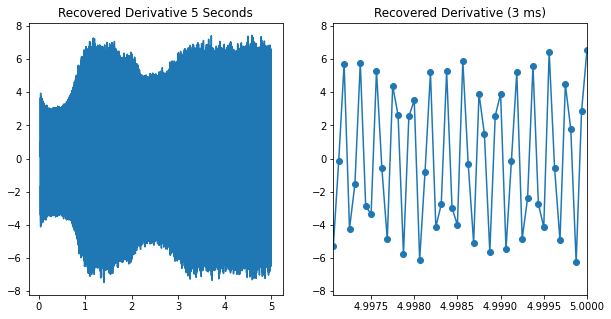

In [14]:
#Unscaled Recovered Values (source derivatives)

# These plots are always shown as they are useful in seeing if the
# source seperation worked as expected
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

    ax1.plot(t1, X_transformed[:,i])
    ax1.set_title('Recovered Derivative ' + str(end_time) + ' Seconds')

    ax2.plot(t1, X_transformed[:,i])
    ax2.scatter(t1, X_transformed[:,i])
    ax2.set_title('Recovered Derivative (3 ms)')
    ax2.set_xlim(t1[-(int(3e-3 / dt))], t1[-1])

In [15]:
# The recovered signal (below) appears to suffer from a low frequency 
# drift overtime (after numerical integration).  Looking at the 
# derivative it seems to be well centered around 0 (especially if 
# you turn off the added noise), so this seems
# like a numerical error. After some googling it seems like this
# is somewhat of a common problem with numerical integration? 
#
# To get around this i just passed the data into a highpass filter 
# with a 50 Hz cutoff. Does this seem reasonable? Filtering the 
# integrated recovered signal has no effect on direction estimation

#Taking at the first signal above:
print('Integration over t: ', np.trapz(X_transformed[:,0],t1))
print('Mean: ', np.mean(X_transformed[:,0]))
print('Max: ', np.max(X_transformed[:,0]))
print('Min: ', np.min(X_transformed[:,0]))

# Looking at these values and plots I would expect the 
# recovered signal to be a sinusoid centered at 0 but 
# the center of the resulting sinusoid changes over time
# shown below

Integration over t:  -0.0014435857331588074
Mean:  -0.0002603998278289044
Max:  7.422011166905394
Min:  -7.468753942057537


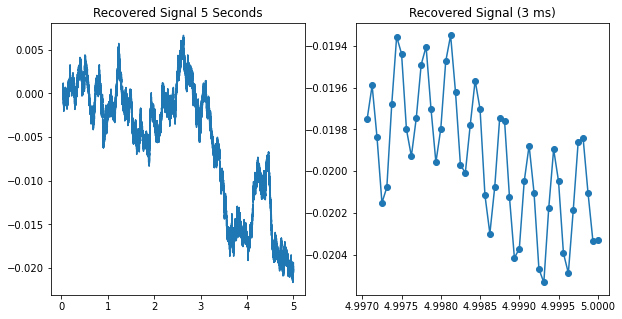

In [16]:
from scipy import integrate
if show_plots:
    for i in range(3):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
        recovered_source = integrate.cumtrapz(X_transformed[:,i], t1, initial=0)
        
        ax1.plot(t1, recovered_source)
        ax1.set_title('Recovered Signal ' + str(end_time) + ' Seconds')
        
        ax2.plot(t1[-(int(3e-3 / dt)):], recovered_source[-(int(3e-3 / dt)):])
        ax2.scatter(t1[-(int(3e-3 / dt)):], recovered_source[-(int(3e-3 / dt)):])
        ax2.set_title('Recovered Signal (3 ms)')
        #ax2.set_xlim(t1[-(int(3e-3 / dt))], t1[-1])

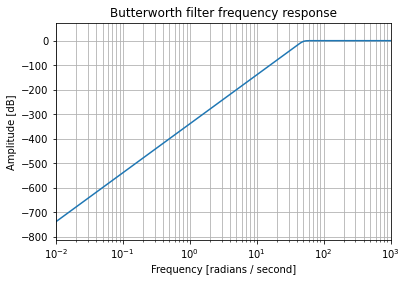

In [17]:
#getting the coeffs for a filter
from scipy import signal

b, a = signal.butter(10, 50, 'highpass', analog=True)
sos = signal.butter(10, 50, 'highpass', fs=(1/dt), output='sos')
w, h = signal.freqs(b, a)
if show_plots:
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.show()

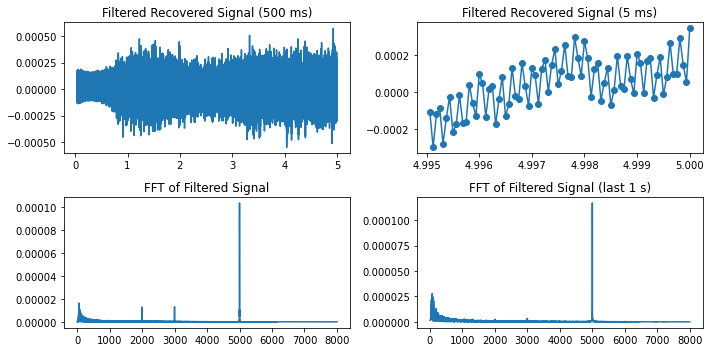

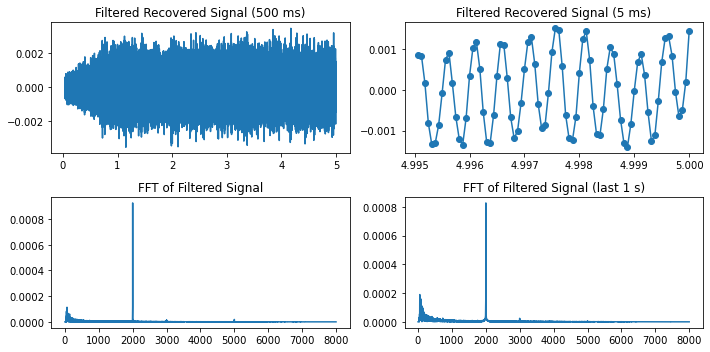

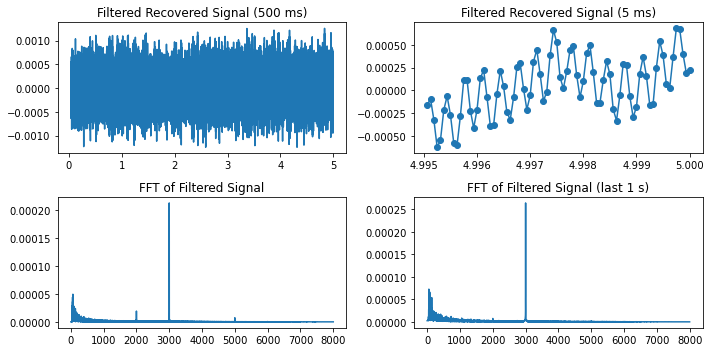

In [18]:
#Recovered Sources
from scipy.fft import fft, fftfreq
center_freqs = np.zeros(3)

for i in range(3):
    recovered_source = integrate.cumtrapz(X_transformed[:,i], t1, initial=0)
    filtered = signal.sosfilt(sos, recovered_source)

    Y = fft(filtered)
    L = len(filtered)
    xf = fftfreq(L, dt)[:L//2]
    
    filtered_cut = filtered[int(0.8*end_time / dt):]
    Y_cut = fft(filtered_cut)
    L_cut = len(filtered_cut)
    xf_cut = fftfreq(L_cut, dt)[:L_cut//2]

    center_freqs[i] = xf_cut[np.abs(Y_cut[0:L//2]).argmax()]

    if show_plots:
        fig, axs = plt.subplots(2,2,figsize=(10,5))
        axs[0,0].plot(t1, filtered)
        axs[0,0].set_title('Filtered Recovered Signal (500 ms)')

        axs[1,0].plot(xf, 2.0/L * np.abs(Y[0:L//2]))
        axs[1,0].set_title('FFT of Filtered Signal')

        axs[0,1].plot(t1[-(int(5e-3 / dt)):], filtered[-(int(5e-3 / dt)):])
        axs[0,1].scatter(t1[-(int(5e-3 / dt)):], filtered[-(int(5e-3 / dt)):])
        axs[0,1].set_title('Filtered Recovered Signal (5 ms)')
        #axs[0,1].set_xlim(t1[-(int(5e-3 / dt))], t1[-1])
        
        #axs[-1, -1].axis('off')
        axs[1,1].plot(xf_cut, 2.0/L_cut * np.abs(Y_cut[0:L_cut//2]))
        axs[1,1].set_title('FFT of Filtered Signal (last 1 s)')
        
        fig.tight_layout()

#I dont think ICA can recover signal ampltiudes, so the derivatives 
#computed earlier (X_tranformed) are likely not the exact source 
#derivatives
# => Recovered signals are not scaled to match the original sources
# but frequency information is retained
#Source: https://sccn.ucsd.edu/pipermail/eeglablist/2014/007575.html



In [19]:
mixer = np.linalg.inv(np.array([[1.000000, -0.462974, 0.090852], 
[6.879779, 1.000000, 2.194700], 
[-1.888184, -0.279993, 1.000000]]))
#mixer = mixer.T

In [20]:
#Normalizing the columns of the mixing matrix to obtain tau
# per the papers
top_val = np.ones(3)
for i in range(0,3):
    top_val[i] = mixer[0,i]
    mixer[:,i] = mixer[:,i]/top_val[i]
mixer

array([[ 1.        ,  1.        ,  1.        ],
       [-6.82797899,  2.67759702,  1.41801439],
       [-0.02360232,  2.63789242, -3.78083264]])

In [21]:
# In order to calculate the directions 
# Multiplying the tau values by c (speed of sound)
# and normalzing to length 1 
# I didnt actually programmatically use the r vectors defined earlier
# This math assumes r1 = [1,0] and r2 = [0,1], turns the dot products
# into scalar products and makes solving much easier

dirs = c * mixer[1:,:]
for i in range(0,3):
    dirs[:,i] = dirs[:,i]/(np.linalg.norm(dirs[:,i]))
np.round(dirs,3)

array([[-1.   ,  0.712,  0.351],
       [-0.003,  0.702, -0.936]])

In [22]:
#Printing Results
#Dir = directly calculated from entered values (ground truth)
#Measured = calculaed with ICA method
#NOTE: as far as i know theres no reason to expect the direction 
#vectors to be in the same order

#Calculating angle as the dot product with [1,0]
#Angle reported in degrees
print()
for i in range(3):
    print('Measured Dir :\t', np.round(dirs[:,i],4),
         '\n\tAngle:\t', np.arccos(dirs[:,i] @ [1,0]) * (180/np.pi),
         '\n\tFreq:\t', center_freqs[i])


Measured Dir :	 [-1.     -0.0035] 
	Angle:	 179.80194608536195 
	Freq:	 5000.259403372244
Measured Dir :	 [0.7124 0.7018] 
	Angle:	 44.572031221166 
	Freq:	 2000.5188067444878
Measured Dir :	 [ 0.3512 -0.9363] 
	Angle:	 69.44126908524298 
	Freq:	 2999.7405966277565


In [23]:
E.shape

(3, 79420)

In [24]:
E_new = E[:, :int(3/dt)]
moving_avg = moving_avg[:,:int(3/dt)]

In [25]:
E_new.shape

(3, 48000)

In [26]:
E = E_new

In [27]:
header = '#include "data.h"\n'
body = ''
for i, arr in enumerate(['de00', 'e10', 'e01']):
    body += 'const float ' + arr + '[] = {\n'
    for j in (E[i,:] - moving_avg[i,:]):
        body += '\t' + str(j) + ',\n'
    body += '};\n\n'
end_note = 'const int N = ' + str(E.shape[1]) + ';'
        

In [28]:
file_out = open('C_v2/data.c', 'w')
file_out.write(header)
file_out.write(body)
file_out.write(end_note)
file_out.close()

In [29]:
C_debug.shape

(3, 3, 79420)

In [34]:
i = int(3/dt)
print(i)
C = C_debug[:,:, i]
print(np.identity(3)-C)

48000
[[ 1.         -0.41476205  0.0713619 ]
 [ 6.4218675   1.          2.23774615]
 [-1.9356038  -0.27269954  1.        ]]
